In [1]:
import os
import sys

# General
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# Metrics
from sklearn.model_selection import train_test_split
from cf_matrix import make_confusion_matrix
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix, make_scorer, average_precision_score,
    plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, roc_curve, auc, balanced_accuracy_score)

# Preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold

# Sampling
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imbl

# Feature Selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV

# Parallelism
from sklearn.pipeline import make_pipeline, Pipeline
from joblib import parallel_backend
from joblib import Parallel, delayed

# Custom helper functions
from utils import *
from data_io import *
from data_representation import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Interpretability

Notebook focused on exploring interpretable models to gain more insight into the problem and provide explainable results (as this is important in the medical context). Using this package here: https://github.com/interpretml/interpret

In [2]:
from interpret import show
from interpret.data import ClassHistogram
from interpret.perf import ROC
from interpret.glassbox import ExplainableBoostingClassifier

# from interpret import set_show_addr
# set_show_addr(('127.0.0.1', 10001))

In [3]:
# Configure Google Colab
def set_colab_folder(path='MyDrive/Colab Notebooks/ML4HC/project2'):
  if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive/')
    path = os.path.join('/content/drive/', path)
    sys.path.append(path)
    %cd $path
  else:
    print('Not running on CoLab')

In [4]:
set_colab_folder()

Not running on CoLab


### Datasets

In [5]:
data_dir = "data"

In [6]:
# Get available datasets and shapes
shapes = get_dataset_shapes()
pd.DataFrame(shapes)

,0,1
0,C_elegans_acc_seq.csv,"(2200, 2)"
1,human_dna_test_hidden_split.csv,"(30021, 1)"
2,human_dna_test_split.csv,"(33333, 2)"
3,human_dna_train_split.csv,"(500000, 2)"
4,human_dna_validation_split.csv,"(33333, 2)"
5,C_elegans_test_split.csv,"(330, 2)"
6,C_elegans_train_split.csv,"(1540, 2)"
7,C_elegans_validation_split.csv,"(330, 2)"


# C Elegans

In [7]:
X_train, y_train = get_data(species='worm', mode='train', form='split')
X_val, y_val     = get_data(species='worm', mode='val',   form='split')
X_test, y_test   = get_data(species='worm', mode='test',  form='split')

100%|██████████| 330/330 [00:00<00:00, 46022.29it/s]


In [8]:
# Use 0/1 labels instead of -1/1 labels
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Class Distribution

In [9]:
print(f"Training: {Counter(y_train)}")
print(f"Validation: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")

Training: Counter({0: 1400, 1: 140})
Validation: Counter({0: 300, 1: 30})
Test: Counter({0: 300, 1: 30})


## Sampling
Tested various sampling schemes and class weights, but achieved best performance by feeding in unsampled data directly

## Training

In [10]:
# Combine validation and training set and use test set to report score
X_train_in = np.concatenate([X_train, X_val])
y_train_in = np.concatenate([y_train, y_val])

In [11]:
# DF to hold scores
res_df = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

In [12]:
# Boosting Classifier
# Performed grid search over various hyperparams, but no significant
# performance improvements have been found over the defaults
ebm_clf = ExplainableBoostingClassifier(
    random_state=42,
    n_jobs=4,
    feature_types = ["categorical" for i in range(len(X_train_in[0]))]
)

ebm_clf.fit(X_train_in, y_train_in)   #Works on dataframes and numpy arrays

_, _, res = pred_results(clf=ebm_clf, X=X_test, y=y_test, model_name="EBM", figsize=None)
res_df = pd.concat([res_df, res], axis=0).reset_index(drop=True)

In [13]:
display(res_df)

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,EBM,0.972727,0.91,0.984778,0.907476


## Model insights

In [14]:
ebm_global = ebm_clf.explain_global(name='EBM')

### Feature importance

As given by the additive terms of the individual boosting contributions of the features we can plot the feature importance for each nucleotide

We can see that the nucleotides close to the splice site and to the left of it are most important for the prediction.

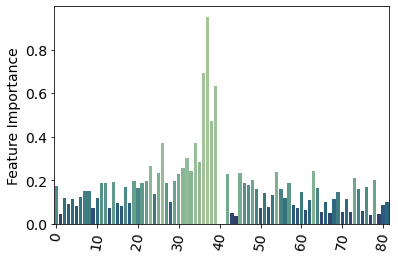

In [47]:
names = ebm_global._internal_obj['overall']['names'][:82]
scores = ebm_global._internal_obj['overall']['scores'][:82]

pal = sns.color_palette("crest", 82)
rank = np.argsort(np.argsort(scores))
ax = sns.barplot(
    x=names,
    y=scores,
    palette=np.array(pal[::-1])[rank]
).set(ylabel="Feature Importance")

locs = list(range(0, 82, 10))
locs, labels = plt.xticks(locs, locs, rotation=80)

plt.savefig("./figures/ebm_worm_importance.svg")

# Human DNA

In [16]:
X_train_h, y_train_h = get_data(species='human', mode='train', form='split')
X_val_h, y_val_h     = get_data(species='human', mode='val', form='split')
X_test_h, y_test_h   = get_data(species='human', mode='test', form='split')
X_hidden_h, _   = get_data(species='human', mode='hidden', form='split')

100%|██████████| 30021/30021 [00:01<00:00, 22050.74it/s]


In [17]:
# Use 0/1 labels
y_train_h[y_train_h < 0] = 0
y_val_h[y_val_h < 0] = 0
y_test_h[y_test_h < 0] = 0

### Class Distribution

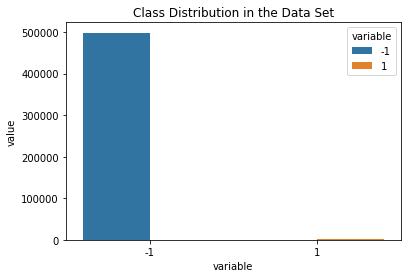

In [18]:
# Plot class distribution on training
plot_class_distribution(y_train_h)

### Sampling
Use a conservative sampling scheme to slightly reduce the imbalance

In [19]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.1)
X_us_h, y_us_h = rus.fit_resample(X_train_h, y_train_h, )

print("{:.0%} of dataset kept.".format(len(y_us_h)/len(y_train_h)))
Counter(y_us_h)

3% of dataset kept.


Counter({0: 14710, 1: 1471})

## Training

In [20]:
f_types = ["categorical" for i in tqdm(range(len(X_train_h[0])))]

100%|██████████| 398/398 [00:00<00:00, 2473085.91it/s]


In [22]:
# DF to hold results
res_df = pd.DataFrame({'model':[],	'f1-score':[],	'balanced_accuracy':[],	'roc_auc':[],	'prc_auc':[]})

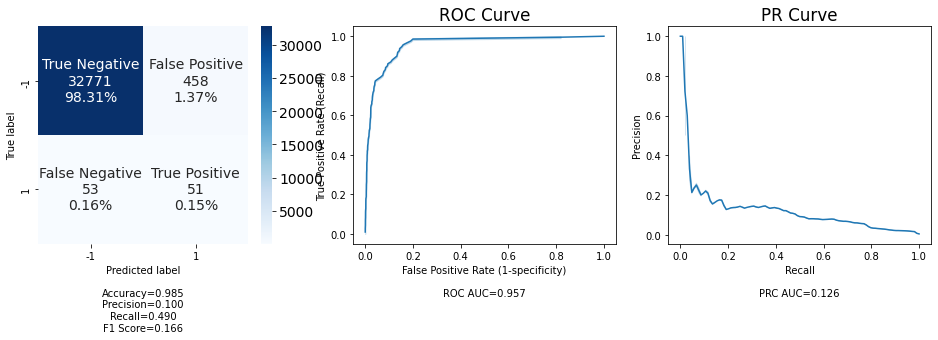

In [23]:
# Boosting Classifier on undersampled dataset
# A grid search has been performed over the available
# hyperparameteres of the boosting machine, but no
# noticeable improvements have been found over the defaults
ebm_clf_us = ExplainableBoostingClassifier(
    random_state=42,
    n_jobs=16, # adjust to fit your system resources
    feature_types = f_types
)

ebm_clf_us.fit(X_us_h, y_us_h)

_, _, res = pred_results(clf=ebm_clf_us, X=X_test_h, y=y_test_h, model_name="EBM Undersampled", figsize=(16, 4))
res_df = pd.concat([res_df, res], axis=0).reset_index(drop=True)

In [24]:
display(res_df)

,model,f1-score,balanced_accuracy,roc_auc,prc_auc
0,EBM Undersampled,0.98467,0.738301,0.95703,0.126036


## Model insights

In [25]:
print("Total length of chain:", X_train_h.shape[1])
print("Middle: ", int(X_train_h.shape[1]/2))

Total length of chain: 398
Middle:  199


In [26]:
# Analyze feature importances for the whole model
emb_us_global = ebm_clf_us.explain_global(name='EBM US')

### Feature importance
Similar observations as on the worm dataset, but it seems to be even more pronounced on the human DNA i.e. only the nucleotides very close to the splice site have a significant predictive influence on the classification result

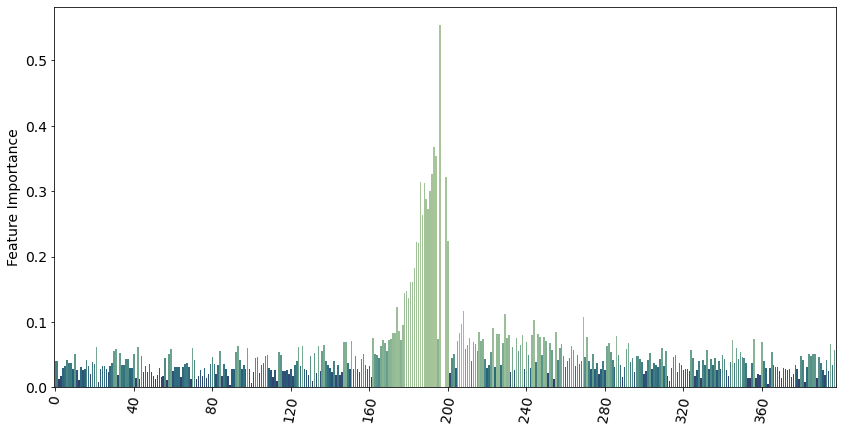

In [46]:
fig, ax = plt.subplots(figsize=(14,7))

names = emb_us_global._internal_obj['overall']['names'][:398]
scores = emb_us_global._internal_obj['overall']['scores'][:398]

pal = sns.color_palette("crest", 398)
rank = np.argsort(np.argsort(scores))
ax = sns.barplot(
    x=names,
    y=scores,
    palette=np.array(pal[::-1])[rank]
).set(ylabel="Feature Importance")

locs = list(range(0, 398, 40))
locs, labels = plt.xticks(locs, locs, rotation=80)

plt.savefig("./figures/ebm_undersampled_humans_importance.svg")

#### Predict on hidden test set

In [41]:
species = "human"
split = "test_hidden"
predictor_identifier = "ebm_undersampled"
threshold = 0.5

print("Shape of hidden dataset", X_hidden_h.shape)
y_proba = ebm_clf_us.predict_proba(X_hidden_h)
y_pred = ebm_clf_us.predict(X_hidden_h)

y_pred[y_pred == 0] = -1 # predict -1/1 labels as in original data

pd.DataFrame(y_pred).to_csv(f"./predictions/{species}_{split}_{predictor_identifier}.csv") # store -1/1 labels
pd.DataFrame(y_proba).iloc[:,1].to_csv(f"./predictions/proba_{species}_{split}_{predictor_identifier}.csv") # store predicted probabilities

Shape of hidden dataset (30021, 398)
